# Fraud Detection for Ethereum
- I meant to make this application for banks in my country however since no bank will be willing to give me their
- data I decided to use info from the with blockchain
- ----
**NOTE** The dataset i am going to use is 5 years old and i found it in kaggle 

## Library and Module imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    ConfusionMatrixDisplay
)
import pickle
import kagglehub
import os

# Create a local cache directory in your project folder
os.environ["KAGGLEHUB_CACHE_DIR"] = "./kagglehub_cache"

## GET and read data from kaggle

In [2]:
path = kagglehub.dataset_download("vagifa/ethereum-frauddetection-dataset")
df = pd.read_csv(f"{path}/transaction_dataset.csv", index_col=0)
df = df.drop(df.columns[[0, 1]], axis=1)
print(df.shape)
df.head()

(9841, 48)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


## Data information and Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

# Convert Objects to Categories
- Categories are more computationally efficient

In [4]:
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,NaN,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [5]:
for i in df[categories].columns:
    print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

The categorical column -- ERC20 most sent token type-- has --304-- unique values
The categorical column -- ERC20_most_rec_token_type-- has --466-- unique values


In [6]:
# Inspect numericals
numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [7]:
# Inspect features variance
df[numericals].var()

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

FLAG
0    7662
1    2179
Name: count, dtype: int64


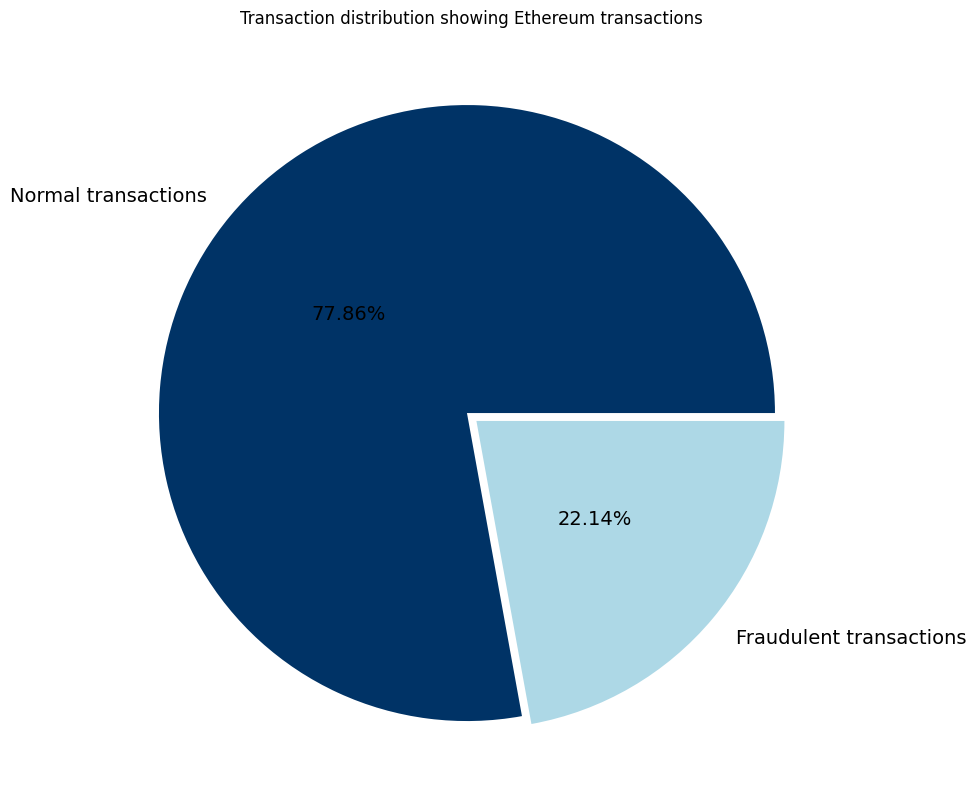

In [8]:
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Normal transactions', 'Fraudulent transactions']
colors = ['#003366', '#ADD8E6']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Transaction distribution showing Ethereum transactions')
plt.show()

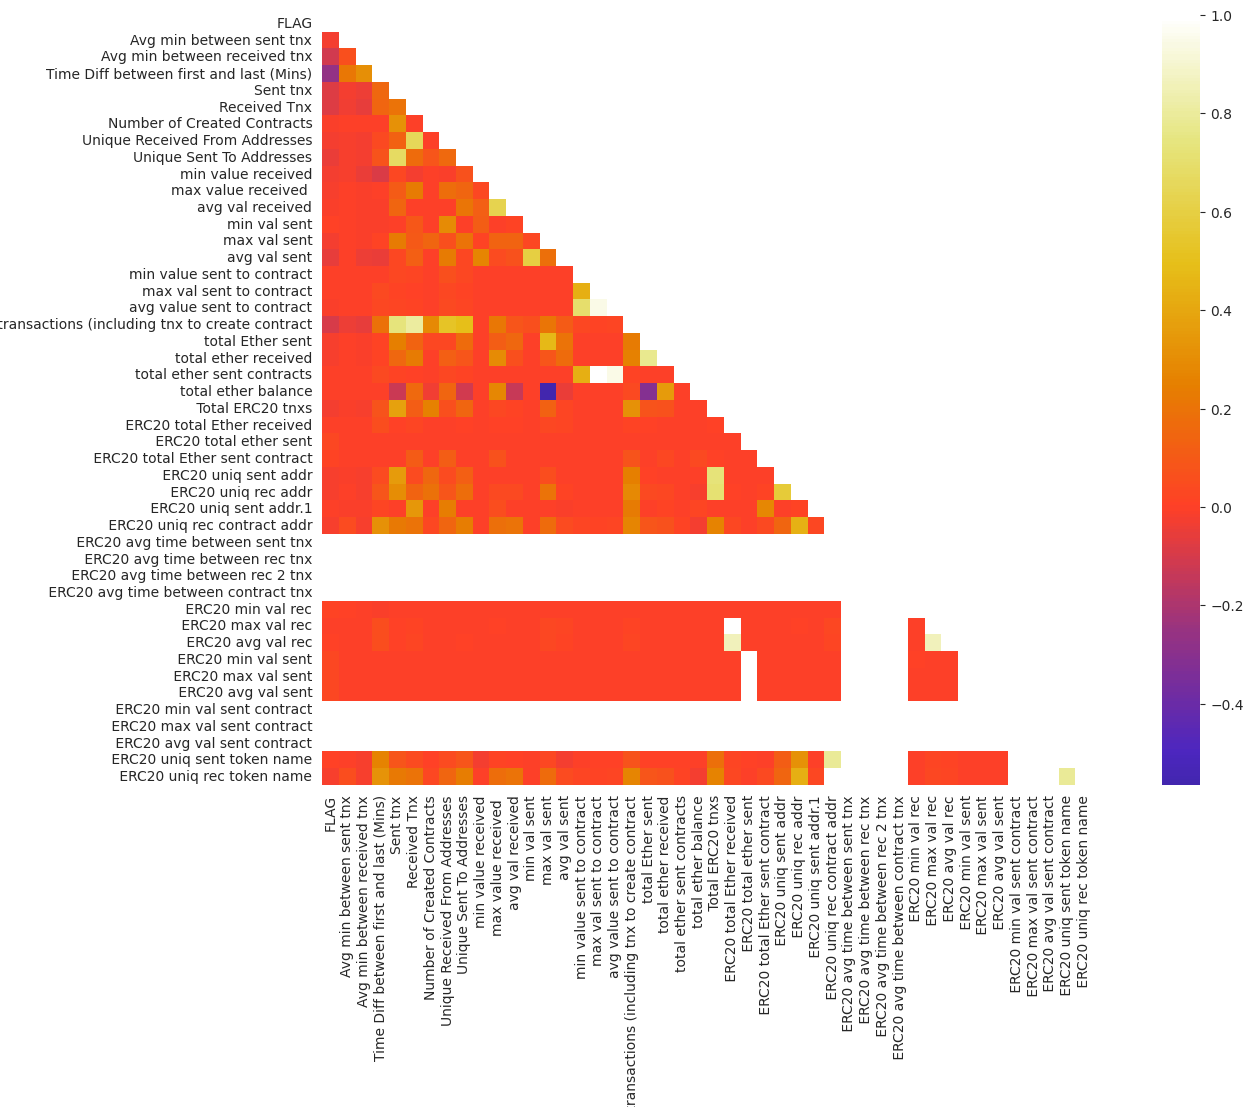

In [9]:
# Correlation matrix
corr = df.corr(numeric_only=True)


mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

## Data Cleaning


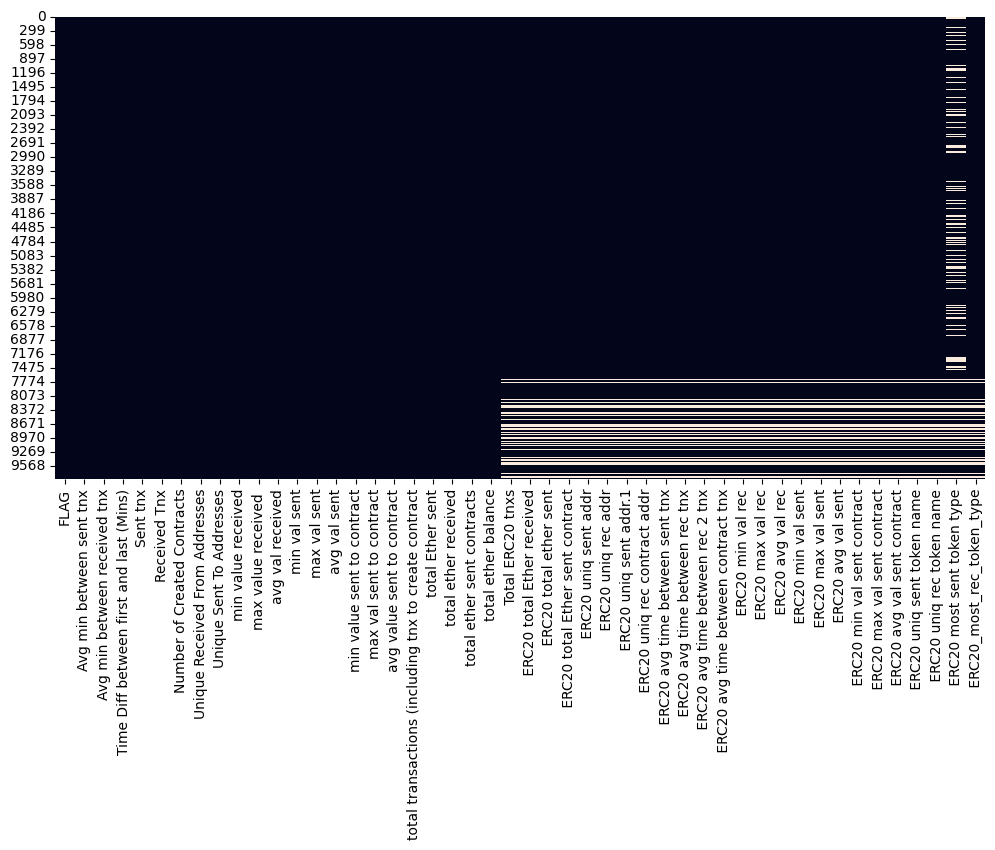

In [10]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [11]:
# List of categorical columns to drop
categories = [' ERC20 most sent token type', ' ERC20_most_rec_token_type']

# Drop the categorical columns
df.drop([col for col in categories if col in df.columns], axis=1, inplace=True)

# Verify the columns after removal
print(df.columns)

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx',
       ' ERC20

In [12]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)


### Now that we have replaced the columns with missing data with the median of the collection we plot a graph to illustrate this change

(9841, 46)


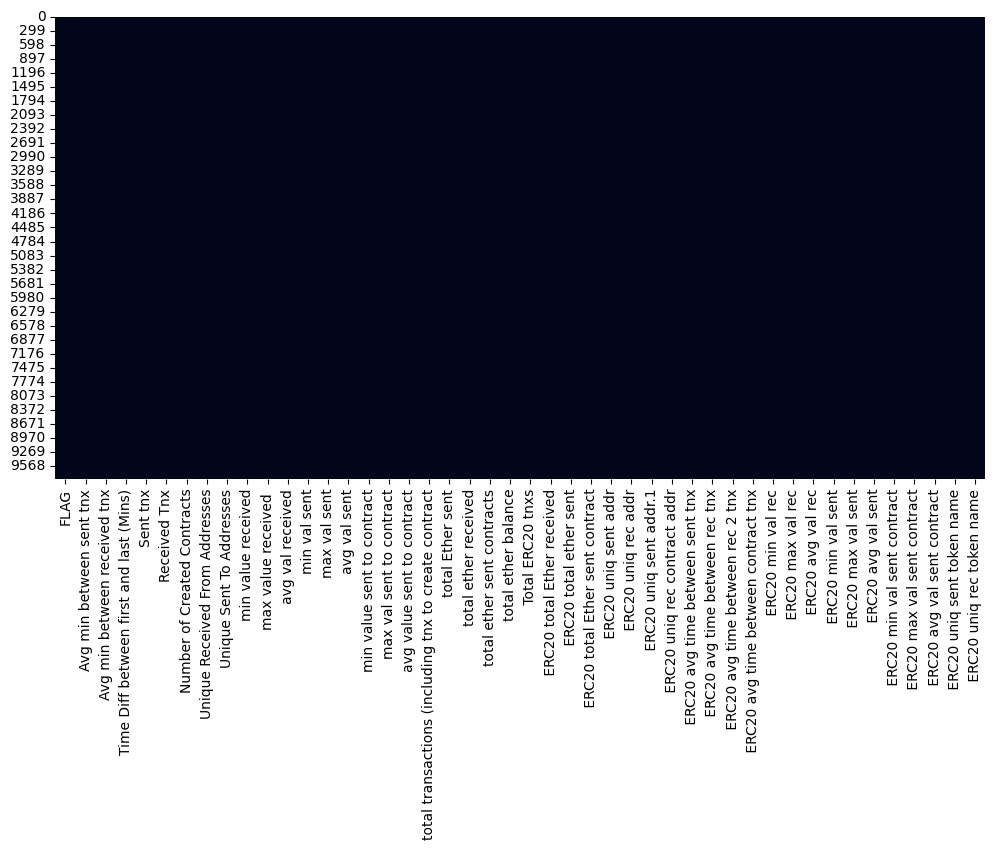

In [13]:
# Visualize missings pattern of the dataframe
print(df.shape)
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [14]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print("------------Dropped Columns----------------")
print(df.var())
print(df.shape)

ERC20 avg time between sent tnx        0.0
ERC20 avg time between rec tnx         0.0
ERC20 avg time between rec 2 tnx       0.0
ERC20 avg time between contract tnx    0.0
ERC20 min val sent contract            0.0
ERC20 max val sent contract            0.0
ERC20 avg val sent contract            0.0
dtype: float64


------------Dropped Columns----------------
FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value receive

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 39 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

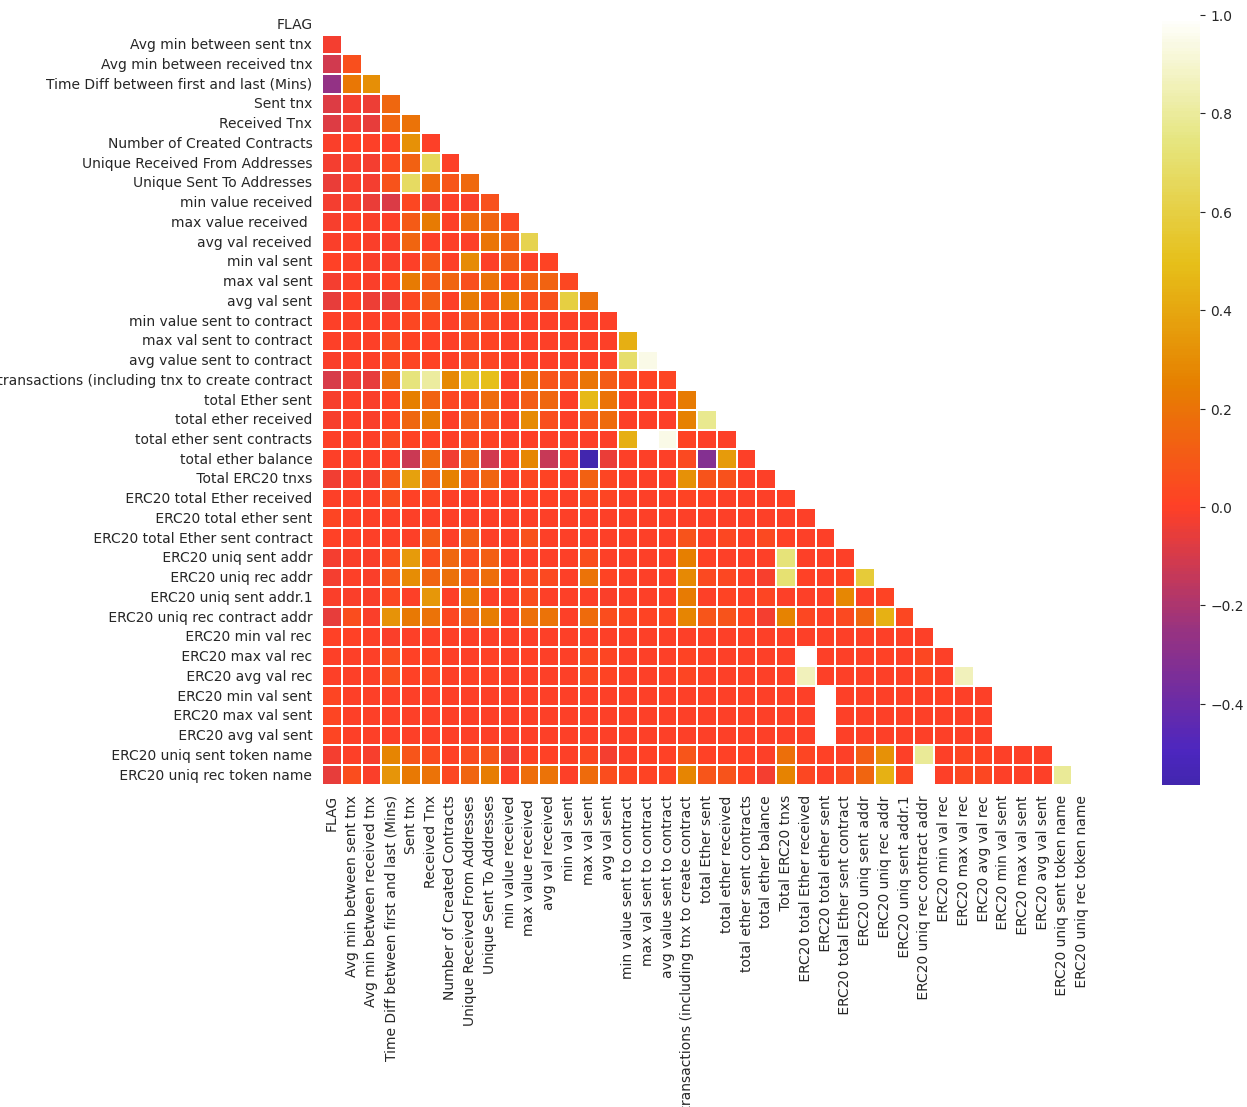

In [16]:
corr = df.corr(numeric_only=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

Drop Highly correlated feautures

In [17]:
# List of columns you want to drop
drop = [
    'total transactions (including tnx to create contract)', 'total ether sent contracts', 'max val sent to contract',
    ' ERC20 avg val rec', ' ERC20 avg val rec', ' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr',
    'max val sent', ' ERC20 avg val sent', ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs',
    'avg value sent to contract', 'Unique Sent To Addresses', 'Unique Received From Addresses', 'total ether received',
    ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr'
]

# Strip any extra spaces from column names
df.columns = df.columns.str.strip()

# Check for missing columns
missing_columns = [col for col in drop if col not in df.columns]
if missing_columns:
    print("These columns are missing from the DataFrame:")
    print(missing_columns)

# Remove only the columns that exist in the DataFrame
drop_existing_columns = [col for col in drop if col in df.columns]

# Drop the existing columns
df.drop(drop_existing_columns, axis=1, inplace=True)

# Verify the remaining columns
print("Remaining Columns:")
print(df.columns)

These columns are missing from the DataFrame:
['total transactions (including tnx to create contract)', ' ERC20 avg val rec', ' ERC20 avg val rec', ' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', ' ERC20 avg val sent', ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', ' ERC20 uniq sent token name', ' ERC20 uniq rec addr']
Remaining Columns:
Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received', 'avg val received',
       'avg val sent', 'min value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether balance', 'Total ERC20 tnxs',
       'ERC20 total Ether received', 'ERC20 total ether sent',
       'ERC20 total Ether sent contract', 'ERC20 uniq sent addr',
       'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1',
       

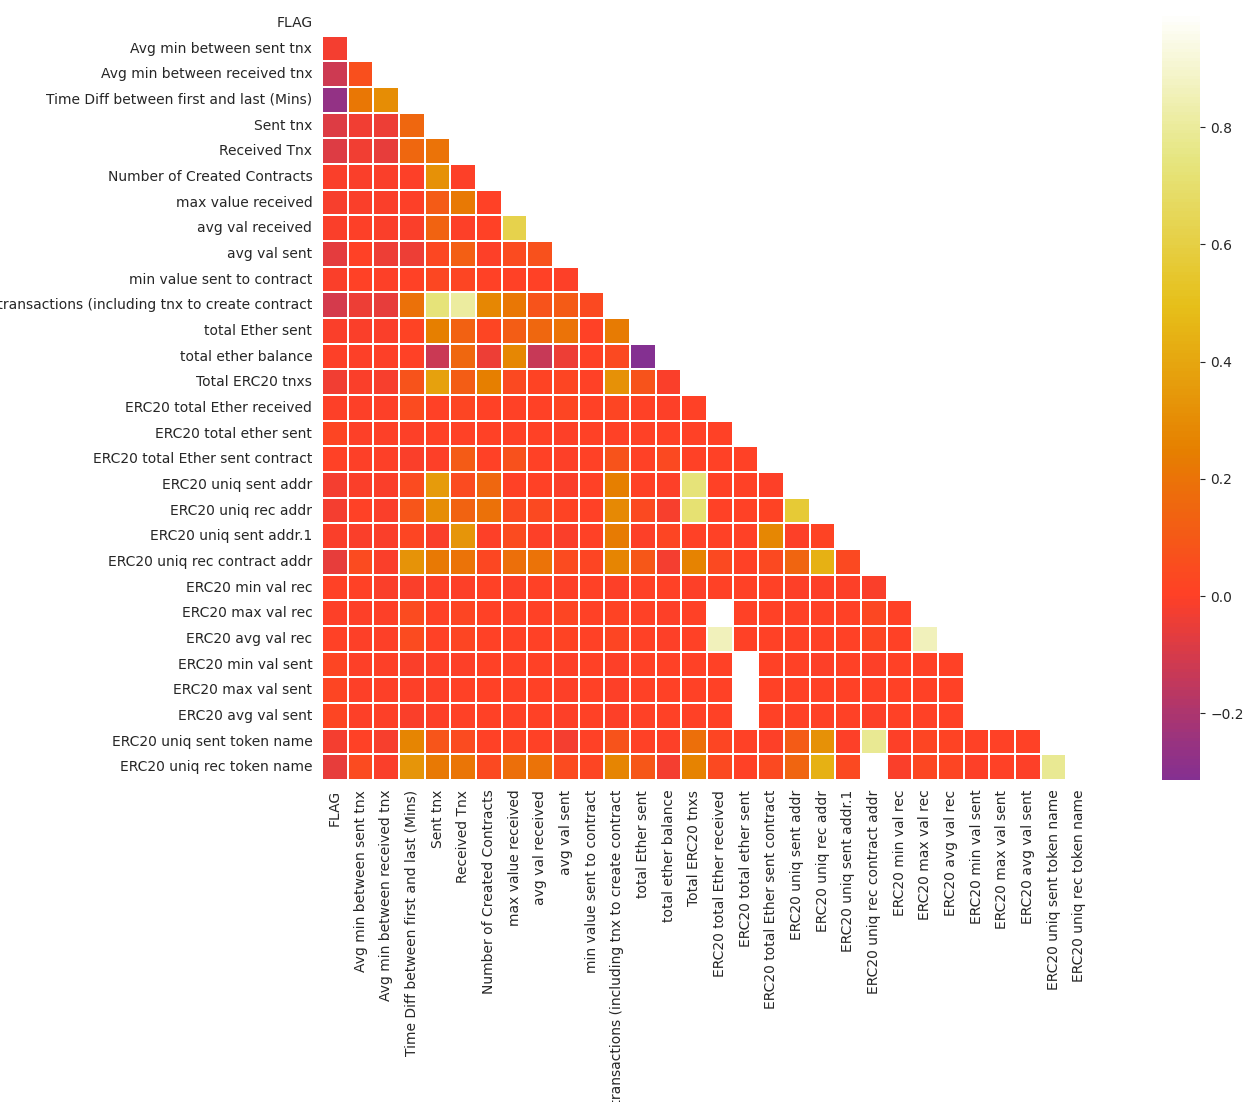

In [18]:
corr = df.corr(numeric_only=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

In [19]:
columns = df.columns
columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received', 'avg val received',
       'avg val sent', 'min value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether balance', 'Total ERC20 tnxs',
       'ERC20 total Ether received', 'ERC20 total ether sent',
       'ERC20 total Ether sent contract', 'ERC20 uniq sent addr',
       'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1',
       'ERC20 uniq rec contract addr', 'ERC20 min val rec',
       'ERC20 max val rec', 'ERC20 avg val rec', 'ERC20 min val sent',
       'ERC20 max val sent', 'ERC20 avg val sent',
       'ERC20 uniq sent token name', 'ERC20 uniq rec token name'],
      dtype='object')

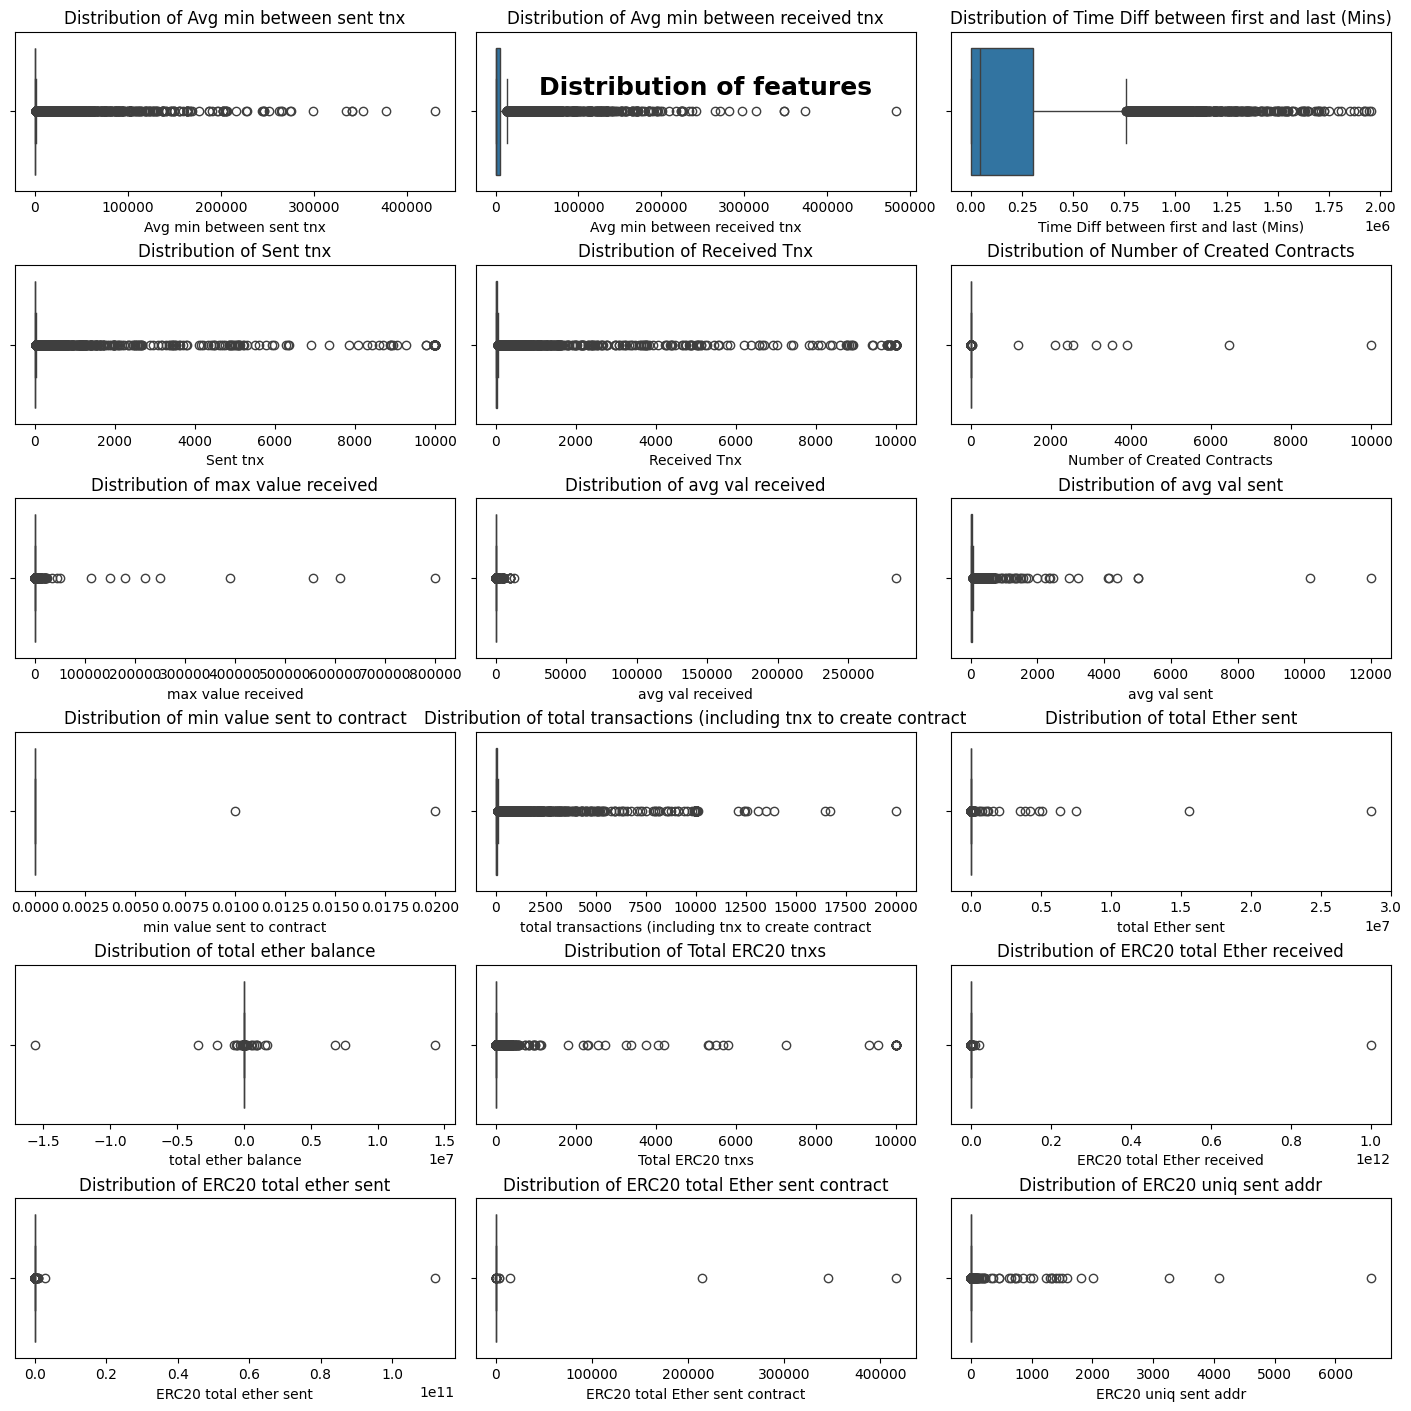

In [20]:
# Investigate the distribution of our features using boxplots
b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')
 
ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')
 
ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')
 
ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

plt.show()

In [21]:
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
min value sent to contract
0.00    9839
0.02       1
0.01       1
Name: count, dtype: int64
The column ERC20 uniq sent addr.1 has the following distribution: 
ERC20 uniq sent addr.1
0.0    9813
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64


In [22]:
# Strip any leading/trailing spaces from the column names
df.columns = df.columns.str.strip()

# Columns to drop
drops = ['min value sent to contract', 'ERC20 uniq sent addr.1']

# Drop the columns
df.drop(drops, axis=1, inplace=True, errors='ignore')

# Print the shape and first few rows to verify
print(df.shape)
print(df.head())

(9841, 28)
   FLAG  Avg min between sent tnx  Avg min between received tnx  \
0     0                    844.26                       1093.71   
1     0                  12709.07                       2958.44   
2     0                 246194.54                       2434.02   
3     0                  10219.60                      15785.09   
4     0                     36.61                      10707.77   

   Time Diff between first and last (Mins)  Sent tnx  Received Tnx  \
0                                704785.63       721            89   
1                               1218216.73        94             8   
2                                516729.30         2            10   
3                                397555.90        25             9   
4                                382472.42      4598            20   

   Number of Created Contracts  max value received  avg val received  \
0                            0           45.806785          6.589513   
1                    

### Data Preparations

In [23]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 27) (9841,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 27) (7872,)
(1969, 27) (1969,)


In [25]:
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [26]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total transactions (including tnx to create contract,...,ERC20 uniq rec addr,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
0,1.294061,1.151313,1.393751,1.591951,1.017881,-0.401539,1.170696,0.988757,0.651223,1.222096,...,1.783833,1.829828,-0.496299,1.793567,1.774207,-0.269174,2.503682,2.500746,2.379702,1.831406
1,-1.096066,-1.184221,-1.638410,-1.391726,-1.785005,-0.401539,-1.407378,-1.283886,-1.138468,-2.084269,...,0.228526,0.224883,-0.496299,-0.741822,-0.745948,-0.269174,-0.410825,-0.410508,-0.437345,0.226082
2,-0.006354,0.213137,1.103220,1.970707,1.876994,-0.401539,0.613575,-0.995919,-0.869934,1.951690,...,-0.995095,-0.993733,-0.496299,-0.741822,-0.745948,-0.269174,-0.410825,-0.410508,-0.437345,-0.994019
3,-1.096066,1.220438,0.195684,-1.391726,-0.618856,2.490307,-0.871196,-0.822389,-1.138468,-0.786382,...,-0.995095,-0.993733,-0.496299,-0.741822,-0.745948,-0.269174,-0.410825,-0.410508,-0.437345,-0.994019
4,0.628503,-1.121221,-0.904665,-0.206187,-0.618856,-0.401539,0.889875,1.277099,1.332663,-0.612613,...,-0.995095,-0.993733,-0.496299,-0.741822,-0.745948,-0.269174,-0.410825,-0.410508,-0.437345,-0.994019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7867,-1.096066,0.249518,-0.705997,-0.590325,-0.618856,-0.401539,-0.535113,-0.269750,0.183532,-0.786382,...,0.228526,0.224883,-0.496299,-0.741822,-0.745948,-0.269174,-0.410825,-0.410508,-0.437345,0.226082
7868,1.128623,0.633621,0.895636,0.707356,1.432439,-0.401539,0.339924,-0.354586,1.043745,1.215570,...,1.131560,1.237037,-0.496299,1.639685,1.630273,-0.269174,-0.410825,-0.410508,-0.437345,1.238838
7869,-1.096066,-1.184221,-1.154101,-0.590325,-1.004903,-0.401539,-1.275895,-1.091970,-0.960939,-1.023619,...,-0.995095,-0.993733,-0.496299,-0.741822,-0.745948,-0.269174,-0.410825,-0.410508,-0.437345,-0.994019
7870,1.385084,0.988959,0.715180,0.707356,0.556810,-0.401539,1.858790,1.531808,1.671553,0.434231,...,1.131560,1.120485,1.832133,1.529580,1.537410,-0.269174,-0.410825,-0.410508,-0.437345,1.122262


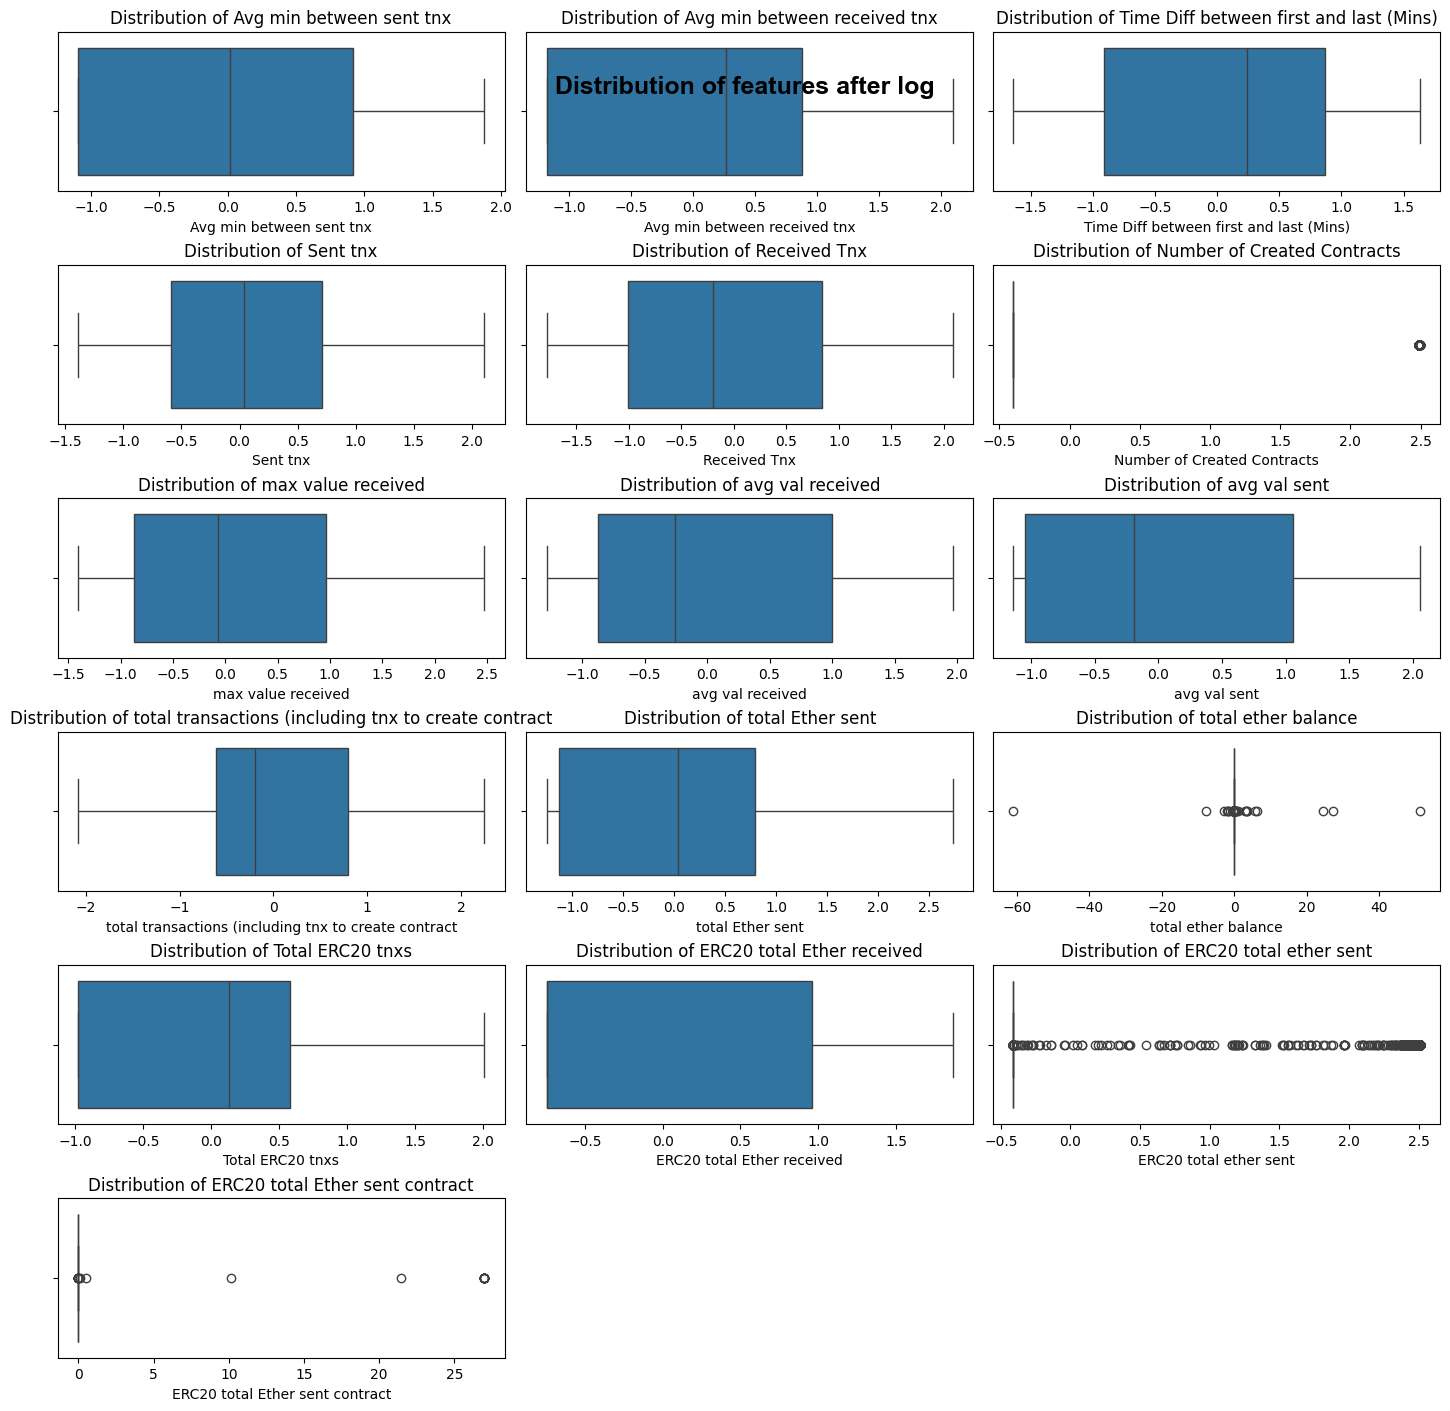

In [27]:
# Distribution of features after transformation

b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
axes[-1, -1].axis('off') # hide axes
axes[-1, -2].axis('off') # hide axes
plt.suptitle("Distribution of features after log",y=0.95, family='Arial', size=18, weight='bold')
 
ax = sns.boxplot(ax = axes[0,0], data=norm_df, x=norm_df.columns[0])
ax.set_title(f'Distribution of {norm_df.columns[0]}')
 
ax1 = sns.boxplot(ax = axes[0,1], data=norm_df, x=norm_df.columns[1])
ax1.set_title(f'Distribution of {norm_df.columns[1]}')
 
ax2 = sns.boxplot(ax = axes[0,2], data=norm_df, x=norm_df.columns[2])
ax2.set_title(f'Distribution of {norm_df.columns[2]}')
 
ax3 = sns.boxplot(ax = axes[1,0], data=norm_df, x=norm_df.columns[3])
ax3.set_title(f'Distribution of {norm_df.columns[3]}')
 
ax4 = sns.boxplot(ax = axes[1,1], data=norm_df, x=norm_df.columns[4])
ax4.set_title(f'Distribution of {norm_df.columns[4]}')
 
ax5 = sns.boxplot(ax = axes[1,2], data=norm_df, x=norm_df.columns[5])
ax5.set_title(f'Distribution of {norm_df.columns[5]}')
 
ax6 = sns.boxplot(ax = axes[2,0], data=norm_df, x=norm_df.columns[6])
ax6.set_title(f'Distribution of {norm_df.columns[6]}')
 
ax7 = sns.boxplot(ax = axes[2,1], data=norm_df, x=norm_df.columns[7])
ax7.set_title(f'Distribution of {norm_df.columns[7]}')
 
ax8 = sns.boxplot(ax = axes[2,2], data=norm_df, x=norm_df.columns[8])
ax8.set_title(f'Distribution of {norm_df.columns[8]}')
 
ax9 = sns.boxplot(ax = axes[3,0], data=norm_df, x=norm_df.columns[9])
ax9.set_title(f'Distribution of {norm_df.columns[9]}')

ax10 = sns.boxplot(ax = axes[3,1], data=norm_df, x=norm_df.columns[10])
ax10.set_title(f'Distribution of {norm_df.columns[10]}')
 
ax11 = sns.boxplot(ax = axes[3,2], data=norm_df, x=norm_df.columns[11])
ax11.set_title(f'Distribution of {norm_df.columns[11]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=norm_df, x=norm_df.columns[12])
ax12.set_title(f'Distribution of {norm_df.columns[12]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=norm_df, x=norm_df.columns[13])
ax13.set_title(f'Distribution of {norm_df.columns[13]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=norm_df, x=norm_df.columns[14])
ax14.set_title(f'Distribution of {norm_df.columns[14]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=norm_df, x=norm_df.columns[15])
ax15.set_title(f'Distribution of {norm_df.columns[15]}')

plt.show()

In [28]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7872, 27), (7872,))
Shape of the training after SMOTE: ((12230, 27), (12230,))


In [29]:
# Target distribution before SMOTE Oversampling
non_fraud = 0
fraud = 0

for i in y_train:
    if i == 0:
        non_fraud +=1
    else:
        fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_tr_resample:
    if j == 0:
        no +=1
    else:
        yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 1757
AFTER OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 6116


## Modelling
We will be Modelling with various models namely:
- Logistic regression
- Random Forest
- XGB boost

In [30]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

In [31]:
print(y_test.shape)
y_test.value_counts()

(1969,)


FLAG
0    1547
1     422
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1547
           1       0.76      0.92      0.83       422

    accuracy                           0.92      1969
   macro avg       0.87      0.92      0.89      1969
weighted avg       0.93      0.92      0.92      1969

[[1425  122]
 [  35  387]]


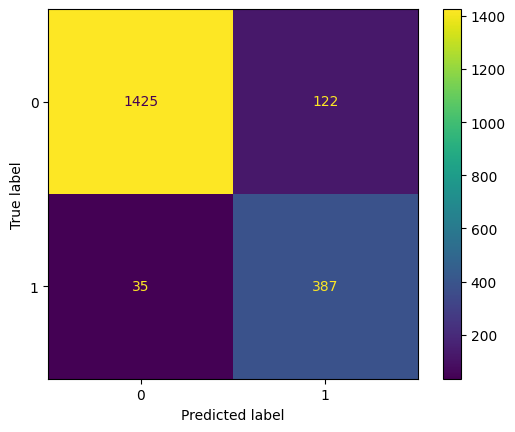

In [32]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
ConfusionMatrixDisplay.from_estimator(LR, norm_test_f, y_test)

Considering the confusion matrix:

Logistic Regression model, correctly identified 373 (TP) of FRAUD cases, out of 422 (P).
Logistic Regression model flagged as FRAUD 171 (FP) out of 1547, when this cases were actually NON-FRAUD
Dealing with a fraud detection scenario, we care more about the transactions that were actualy FRAUDS, but which were treated as NON-FRAUD by our model (FN - 49) TYPE II ERROR

Therby, let's try to increase the recall using other methods.

### Random Forest Model

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1547
           1       0.96      0.96      0.96       422

    accuracy                           0.98      1969
   macro avg       0.97      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1528   19]
 [  18  404]]


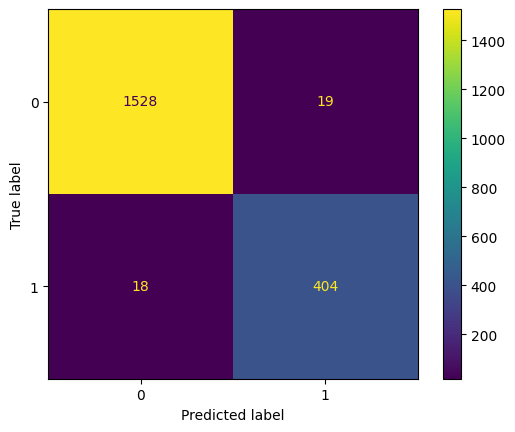

In [33]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))
ConfusionMatrixDisplay.from_estimator(RF, norm_test_f, y_test)

The Random Forest Model seems to produce better results than The Logistic Regression
- Both FP and FN are reduced considerably increasing the recall & precision
- Using Random Forest, the model fails to detect 20 FRAUD cases.

### XGB Classifier

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1547
           1       0.95      0.96      0.96       422

    accuracy                           0.98      1969
   macro avg       0.97      0.98      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1527   20]
 [  15  407]]


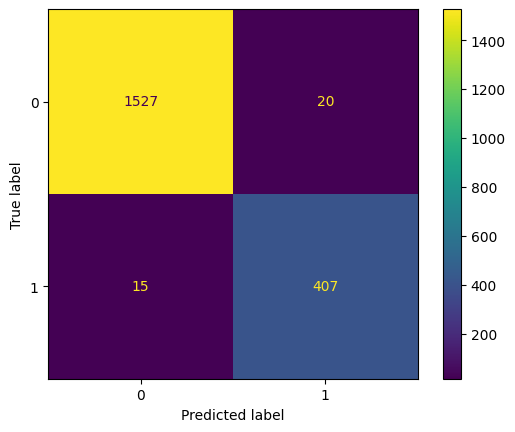

In [34]:
xgb_c = xgb.XGBClassifier(random_state=42)
xgb_c.fit(x_tr_resample, y_tr_resample)
preds_xgb = xgb_c.predict(norm_test_f)

print(classification_report(y_test, preds_xgb))
print(confusion_matrix(y_test, preds_xgb))
ConfusionMatrixDisplay.from_estimator(xgb_c, norm_test_f, y_test)

The results of XGBClassifier shows that its doing slightly better than the Random Forest when it comes to NON-FRAUD transactions, flagging 22 cases as fraud when they were actually non-fraud.

Wen it comes to identifiying FRAUDS, XGBClassifier missed 16 transactions out of 422, suggesting the best recall score.

Considering that, the XGBClassifier is the choice that we want.

Let's see if we can improve these results by finetuning the parameters

In [35]:
params_grid = {'learning_rate':[0.01, 0.1, 0.5],
              'n_estimators':[100,200],
              'subsample':[0.3, 0.5, 0.9],
               'max_depth':[2,3,4],
               'colsample_bytree':[0.3,0.5,0.7]}

grid = GridSearchCV(estimator=xgb_c, param_grid=params_grid, scoring='recall', cv = 10, verbose = 0)

grid.fit(x_tr_resample, y_tr_resample)
print(f'Best params found for XGBoost are: {grid.best_params_}')
print(f'Best recall obtained by the best params: {grid.best_score_}')

Best params found for XGBoost are: {'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Best recall obtained by the best params: 0.9919824994918862


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1547
           1       0.95      0.96      0.95       422

    accuracy                           0.98      1969
   macro avg       0.97      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1524   23]
 [  18  404]]


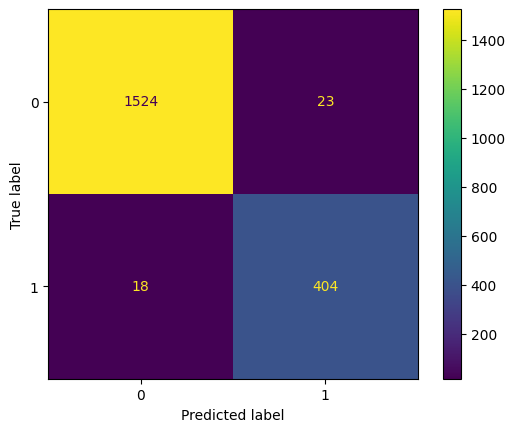

In [36]:
preds_best_xgb = grid.best_estimator_.predict(norm_test_f)
print(classification_report(y_test, preds_best_xgb))
print(confusion_matrix(y_test, preds_best_xgb))
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, norm_test_f, y_test)

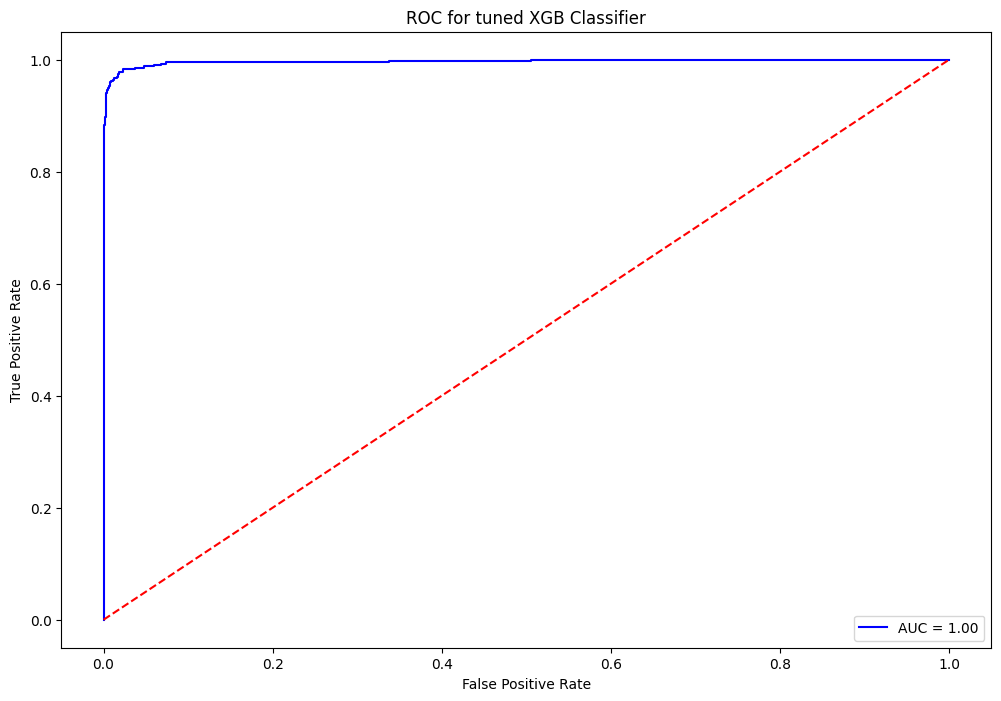

In [37]:
# Plotting AUC for untuned XGB Classifier
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for tuned XGB Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The XGB boost tuned model performed the best hence we save it.

In [38]:
# Save the model for further use
pickle_out = open('XGB_FRAUD.pickle', 'wb')
pickle.dump(xgb_c, pickle_out)
pickle_out.close()